# 1. Project setup

In [2]:
# Import necessary libraries and modules
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import os
import seaborn as sns
import random

from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from typing import List, Dict, Tuple, Union
from timeit import default_timer as timer
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo. Installing.")
    !pip install -q torchinfo
    from torchinfo import summary

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() == True else "cpu"
device

'cpu'

# 2. Data preparation

## 2.1 Load data

In [4]:
# Load the CSV data using pandas
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [5]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Break up the training DataFrame into features and labels
X_train = train_df.drop(labels=["label"], axis=1)
y_train = train_df["label"]

# Check number of entries or samples for each class
y_train.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

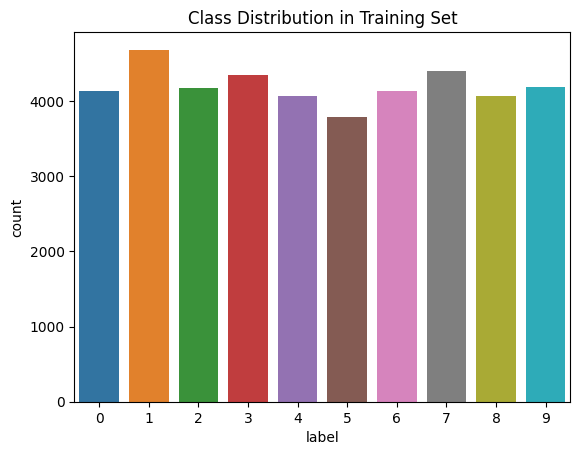

In [8]:
# Check number of entries or samples for each class with a graph using seaborn
sns.countplot(x=train_df["label"])
plt.title("Class Distribution in Training Set");

## 2.2 Check for `Null` and `NaN` values

In [9]:
# Check the data
print(train_df.isna().sum().any())
print(train_df.isnull().sum().any())
print(test_df.isna().sum().any())
print(test_df.isnull().sum().any())

False
False
False
False


There are no `Null` and `NaN` (missing) values. Therefore, we can safely proceed.

## 2.3 Partitioning training data

In [10]:
# Split up our training DataFrame inorder to create the validation DataFrame to validate our model
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=42)

In [11]:
X_val

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
5457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38509,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25536,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8388,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
y_val

5457     8
38509    1
25536    9
31803    9
39863    8
        ..
8388     4
29359    9
40276    3
18421    0
4335     9
Name: label, Length: 8400, dtype: int64

In [13]:
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
34941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24433,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2.4 Visualize data

Displaying a few sample images from the dataset helps in getting to know the data better. It helps in EDA (explatory data analysis).

For display purposes, num_samples shouldn't be larger than 10, setting to 10.


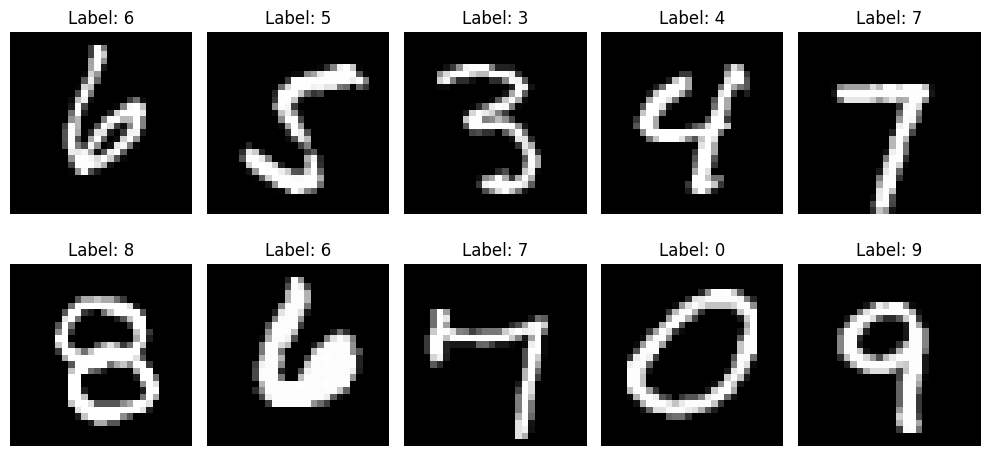

In [14]:
def plot_samples(X, y, num_samples: int=10):
    # Adjust number of samples if it is too high
    if num_samples > 10:
        num_samples = 10
        print("For display purposes, num_samples shouldn't be larger than 10, setting to 10.")
        pass
    plt.figure(figsize=(10, 5))
    
    # Displaying the images
    for i in range(num_samples):
        plt.subplot(2, 5, i+1)
        plt.imshow(X.iloc[i].values.reshape(28, 28), cmap="gray")
        plt.title(f"Label: {y.iloc[i]}")
        plt.axis(False)
    plt.tight_layout()
    plt.show()
    
# Plot samples from training data
plot_samples(X_train, y_train, num_samples=15)

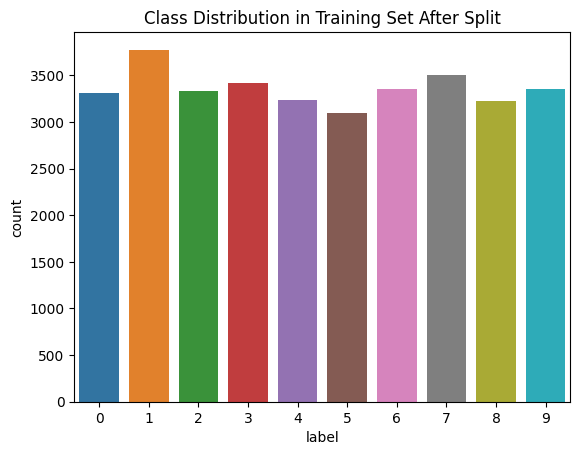

In [15]:
# Check class distribution of training set after splitting of data
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set After Split");

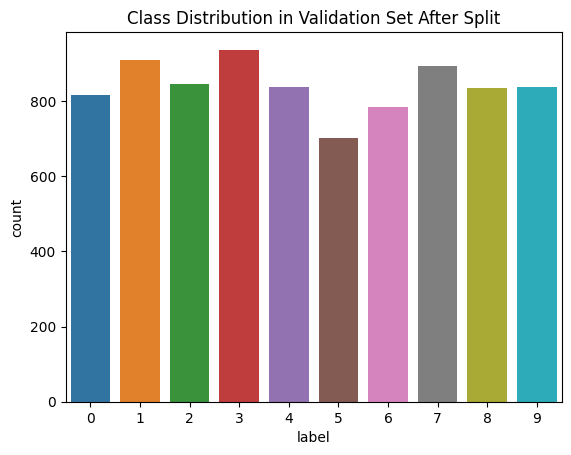

In [16]:
# Check class distribution of validation set after splitting of data
sns.countplot(x=y_val)
plt.title("Class Distribution in Validation Set After Split");

We can tell that our data has been split properly, so we are ready to proceed.

## 2.5 Concatenate validation and training separately

In [17]:
# Reset the indices of X_val and y_val to ensure they align properly
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

The `reset_index(drop=True)` method ensures that the indices of `y_val` and `X_val` are reset so they match the indices of eachother to avoid any chances of having NaN values. If their will be NaN values, they will cause a huge problem later on when we train our model.

In [18]:
# Join X_val and y_val back into a singe DataFrame to create our validation DataFrame
val_df = pd.concat([X_val, y_val], axis=1)
val_df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
8396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
8397,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
8398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This concatenates `X_val` and `y_val` along the columns to form a single DataFrame.

In [19]:
# Ensure the label column is the first column
val_df = val_df[["label"] + [col for col in val_df.columns if col != "label"]]
val_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8396,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8397,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Reset the indices of X_val and y_val to ensure they align properly
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

The `reset_index(drop=True)` method ensures that the indices of `y_train` and `X_train` are reset so they match the indices of eachother to avoid any chances of having NaN values. If their will be NaN values, they will cause a huge problem later on when we train our model.

In [21]:
# Join X_train and y_train back into a single DataFrame to create our training DataFrame
train_df = pd.concat([X_train, y_train], axis=1)
train_df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
33596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
33597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
33598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


This concatenates `X_train` and `y_train` along the columns to form a single DataFrame.

In [22]:
# Ensure the label column is the first column
train_df = train_df[["label"] + [col for col in train_df.columns if col != "label"]]
train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33595,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33596,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33597,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33598,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Check the data for Null and NaN values
print(train_df.isna().sum().any())
print(train_df.isnull().sum().any())
print(val_df.isna().sum().any())
print(val_df.isnull().sum().any())

False
False
False
False


# 3. Create Datasets and DataLoaders

Normalization is a key concept in data preprocessing steps and is a very important concept to understand. 

Furthermore, normalization is just a preprocessing technique used to adjust the scale of the data to make it more suitable for training machine/deep learning models.

You may ask, why do we perform normalization?

* Convergence Speed: Speeds up neural network training by stabilizing weights and gradients.
* Illumination: Reduces sensitivity to varying lighting (how light or dark an image appears) conditions, focusing on patterns rather than absolute intensities.
* Consistency: Ensures all input features are on the same scale, improving data consistency.

In summary, normalizing to [0, 1] makes training easier, reduces the impact of lighting changes, and ensures consistent input values.

## 3.1 Create and instantiate custom Dataset class

Remember, we have to create a custom `Dataset` class as PyTorch does not have a prebuilt custom class for this type of data. Also, we must redefine the `__getitem__` function as we are subclassing the `Dataset` class. Since we will be using `TrivialAugmentWide()`, we must transform our image into a PIL Image beforehand in order to use it, as its required. 

In [24]:
class DigitDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, train: bool = True):
        """
        Initialize the dataset.

        Parameters:
        - dataframe: A pandas DataFrame containing the data.
        - train: Whether the dataset is for training (includes labels) or testing (no labels).
        """
        self.data = dataframe.values
        self.train = train
        self.num_columns = len(dataframe.columns)
        
        # Define transformations
        if self.train == True:
            self.transform = transforms.Compose([
                transforms.ToPILImage(), # Convert NumPy array to PIL Image
                transforms.TrivialAugmentWide(), # Apply a wide variety of data augmentations
                transforms.ToTensor(), # Convert PIL Image to tensor and scale to [0, 1]
                transforms.Normalize(mean=(0.5,), std=(0.5,)) # Normalize the tensor
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(), # Convert NumPy array to tensor and scale to [0, 1]
                transforms.Normalize(mean=(0.5,), std=(0.5,)) # Normalize the tensor
            ])
            
    def __len__(self) -> int:
        """Return the number of samples in the dataset."""
        return len(self.data)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Union[torch.Tensor, None]]:
        """
        Retrieve a sample from the dataset at the given index.

        Parameters:
        - idx: The index of the sample to retrieve.

        Returns:
        - A tuple containing the sample (features and label) for training, or just features for testing.
        """
        data_sample = self.data[idx]
        
        if self.num_columns == 785:
            features = data_sample[1:].reshape(28, 28, 1) # For training and validation DataFrames as they have a label column
        else:
            features = data_sample.reshape(28, 28, 1)  # For testing DataFrame as it doesn't have a label column
        
        # Apply transformations
        features = self.transform(features.astype(np.uint8))  # Convert to uint8 for PIL Image compatibility
        
        if self.num_columns == 785:
            label = int(data_sample[0])
            return features, torch.tensor(label, dtype=torch.long)
        else:
            return features
        

The `transforms.ToPILImage()` function from `torchvision.transforms` is used to convert tensors or NumPy arrays into PIL Images. It expects input data in tensor format with shape `(C, H, W)` (for tensors) or `(H, W)`/`(H, W, C)` (for NumPy arrays), where `C` denotes the number of channels, and `H` and `W` represent the height and width of the image. Pixel values should generally be in the range `[0, 1]` for floating-point tensors or `[0, 255]` for integer types.

In [25]:
# Create an instance of the training, validation, and test datasets
train_data = DigitDataset(dataframe=train_df, train=True)
val_data = DigitDataset(dataframe=val_df, train=False)
test_data = DigitDataset(dataframe=test_df, train=False)

train_data, val_data, test_data

(<__main__.DigitDataset at 0x7aee4e704430>,
 <__main__.DigitDataset at 0x7aee4e704c10>)

## 3.2 Identifying and storing image classes

The `.append()` and `.extend()` methods are used to modify lists in Python. `.append()` adds a single element to the end of a list, regardless of its type, which may include another list. For example, `my_list.append([4, 5])` adds `[4, 5]` as a single element. In contrast, `.extend()` iterates over an iterable (like another list or tuple) and adds each of its elements to the list. For instance, `my_list.extend([4, 5])` adds each element of `[4, 5]` individually.

In [26]:
# Initialize a list to store labels
all_labels = []

# Iterate through the dataset to collect all labels
for image, label in train_data:
     all_labels.append(label.tolist())
        
# Convert the list to a unique list of class names
class_names = list(set(all_labels))
class_names

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## 3.3 Display random images

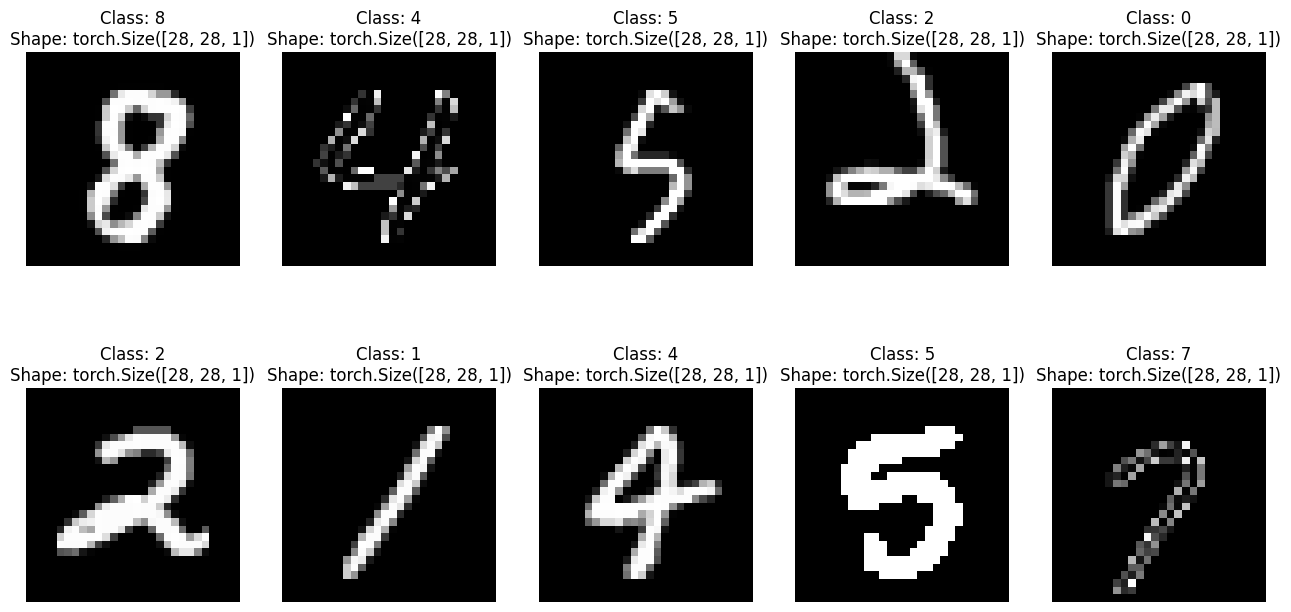

In [27]:
# Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # Adjust display and n if n is too high    
    if n > 10:
        n = 10
        display_shape = False
        print("For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
        
    # Set random seed if give
    if seed:
        random.seed(seed)
        
    # Get random sample indexes (random sampling)
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    
    # Setup plot
    plt.figure(figsize=(16, 8))
    
    # Loop through the samples and display them randomly
    for i, sample in enumerate(random_samples_idx):
        image, label = dataset[sample][0], dataset[sample][1]
        
        # Adjust image tensor shape for plotting: [color_channels, height, width] -> [height, width, color_channels]
        image = image.permute(1, 2, 0)
        
        # Plot adjusted samples
        plt.subplot(2, 5, i+1)
        plt.imshow(image, cmap="gray")
        plt.axis(False)
        title = ""
        if classes:
            title = f"Class: {classes[label]}"
            if display_shape:
                title = title + f"\nShape: {image.shape}"
        plt.title(title);
        
# Display random images from custom DigitDataset
display_random_images(train_data,
                      n=10,
                      classes=class_names)

**NHWC**: (Used by TensorFlow, Matplotlib, NumPy)

N: Number of samples. H: Height of the input data. W: Width of the input data. C: Number of channels (e.g., RGB for images)

**NCHW**: (Used by PyTorch)

N: Number of samples. C: Number of channels (e.g., RGB for images) H: Height of the input data. W: Width of the input data.

## 3.4 Turn custom loaded data into DataLoaders 

Setting `pin_memory=True` in a PyTorch `DataLoader` helps speed up the transfer of data from your computer's memory to the GPU. This makes training faster and smoother when using a GPU. It's usually a good idea to enable this if you're using a GPU.

In [28]:
# Setup hyperparameters
BATCH_SIZE = 100
NUM_WORKERS = os.cpu_count()

# Turn custom/loaded data/images into DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True,
                              pin_memory=True)
val_dataloader = DataLoader(dataset=val_data,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=False,
                            pin_memory=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             pin_memory=True)

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7aee4e3ebfa0>,
 <torch.utils.data.dataloader.DataLoader at 0x7aee4e4186d0>)

# 4. Create model with data augmentation : `TinyVGG`

Now, we will create our model with augmented data. Our data already has been augmented in our custom `Dataset` class. Therefore, we don't have to do it again.

You may ask, what is data augmentation?

Well, data augmentation is a technique used to artificially increase the size of a dataset by creating modified versions of existing data. This includes transformations like rotating, flipping, or changing the color of images. It helps improve a model's performance by making it more robust and better at handling variations in real-world data. 

The data augmentation part in our code is the `transforms.TrivialAugmentWide()` in the `self.transforms` in the custom `DigitDataset` class.

## 4.1 Create TinyVGG model class

For this project for recognizing digits, I will be using the TinyVGG architecture. Learn more about it here - https://poloclub.github.io/cnn-explainer/. Except, I would be increasing the number of hidden units to improve the model as 10 hidden units are not sufficient.

In [29]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
        
    def forward(self,
                x: torch.Tensor()) -> torch.Tensor():
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # Leverage benefits of operator fusion
    
model_0 = TinyVGG(input_shape=1,
                  hidden_units=64,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=10, bias=True)
  )
)

## 4.2 Try a forward pass on a single image

This allows us to test our model and see if it is working. It helps us out if there are any shape errors like the one I had for the `in_features` of the `nn.Linear` layer in the `self.classifier` block.

In [30]:
# 1. Get a batch of images and labels from the DataLoader
image_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
image_single, label_single = image_batch[0].unsqueeze(dim=0).to(device), label_batch[0].to(device)
print(f"Single Image Shape:\n{image_single.shape}\n")

# Make a prediction on that single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(image_single)
    pred_prob = pred.softmax(dim=1)
    pred_label = pred_prob.argmax(dim=1)
    
# Print out what's happening throughout the prediction process
print(f"Output Logit:\n{pred}\n")
print(f"Output Prediction Probabilitie:\n{pred_prob}\n")
print(f"Output Prediction Label:\n{pred_label}\n")
print(f"Actual Label:\n{label_single}")

Single Image Shape:
torch.Size([1, 1, 28, 28])

Output Logit:
tensor([[-0.0559,  0.0446, -0.0586, -0.0246,  0.0056, -0.0101,  0.0382, -0.0079,
         -0.0024, -0.0173]])

Output Prediction Probabilitie:
tensor([[0.0954, 0.1054, 0.0951, 0.0984, 0.1014, 0.0998, 0.1048, 0.1000, 0.1006,
         0.0991]])

Output Prediction Label:
tensor([1])

Actual Label:
9


## 4.3 Getting a summary of our model with `torchinfo.summary()`

In [31]:
# Print a summary using torchinfo
summary(model=model_0,
        input_size=(1, 1, 28, 28),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
TinyVGG (TinyVGG)                        [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (conv_block_1)              [1, 1, 28, 28]       [1, 64, 14, 14]      --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 64, 28, 28]      640                  True
│    └─ReLU (1)                          [1, 64, 28, 28]      [1, 64, 28, 28]      --                   --
│    └─Conv2d (2)                        [1, 64, 28, 28]      [1, 64, 28, 28]      36,928               True
│    └─ReLU (3)                          [1, 64, 28, 28]      [1, 64, 28, 28]      --                   --
│    └─MaxPool2d (4)                     [1, 64, 28, 28]      [1, 64, 14, 14]      --                   --
├─Sequential (conv_block_2)              [1, 64, 14, 14]      [1, 64, 7, 7]        --                   True
│    └─Conv2d (0)   

# 5. Train `TinyVGG` model

In [32]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(params=model_0.parameters(),
                                lr=0.001)

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              mode="max",
                              factor=0.5,
                              patience=3,
                              min_lr=0.00001,
                              verbose=1)

`ReduceLROnPlateau()` adjusts the learning rate when a metric has stopped improving. In this case, the metric is the validation accuracy or `val_acc`.

Here’s a breakdown of the parameters:
- `monitor='val_acc'`: Monitors the validation accuracy. When this metric stops improving, the learning rate will be reduced.
- `patience=3`: Number of epochs to wait for improvement before reducing the learning rate.
- `verbose=1`: Prints a message when the learning rate is reduced.
- `factor=0.5`: The factor by which the learning rate will be reduced (e.g., if the learning rate was 0.01, it will be reduced to 0.005).
- `min_lr=0.00001`: The minimum learning rate to which it can be reduced.
- `mode='max'`: Specifies whether higher values of the metric are better (e.g., accuracy), or 'min' if monitoring a metric where lower values are preferable (e.g., loss).

In [33]:
def train_step(model: torch.nn.Module,
               train_dataloader: torch.utils.data,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               accuracy_score: sklearn.metrics = accuracy_score,
               device: torch.device = device):
    # Put the model in training mode
    model.train()

    # Setup train loss and train accuracy
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        # Send the data to the target device
        X_train, y_train = X_train.to(device), y_train.to(device)

        # 1. Forward propagation
        y_logits = model(X_train)
        y_preds = y_logits.argmax(dim=1)

        # 2. Calculate the loss and accuracy
        loss = loss_fn(y_logits, y_train)
        train_loss += loss.item()
        acc = accuracy_score(y_train.cpu().numpy(), y_preds.cpu().numpy())*100
        train_acc += acc

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimizer step (gradient descent)
        optimizer.step()

    # Calculate the loss and accuracy per epoch
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    return train_loss, train_acc

In [34]:
def val_step(model: torch.nn.Module,
             val_dataloader: torch.utils.data,
             loss_fn: torch.nn.Module,
             accuracy_score: sklearn.metrics = accuracy_score,
             device: torch.device = device):
    # Put the model in evaluation mode
    model.eval()

    # Setup val loss and val accuracy
    val_loss, val_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through data loader data batches
        for (X_val, y_val) in val_dataloader:
            # Send the data to the target device
            X_val, y_val = X_val.to(device), y_val.to(device)

            # 1. Forward propagation
            val_logits = model(X_val)
            val_preds = val_logits.argmax(dim=1)

            # 2. Calculate the loss and accuracy
            val_loss += loss_fn(val_logits, y_val).item()
            val_acc += accuracy_score(y_val.cpu().numpy(), val_preds.cpu().numpy())*100

        # Calculate the loss and accuracy per epoch
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        return val_loss, val_acc

In [35]:
# Import tqdm for a progress bar
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data,
          val_dataloader: torch.utils.data,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim,
          epochs: int,
          accuracy_score: sklearn.metrics = accuracy_score,
          device: torch.device = device):
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}

    # Loop through training and validation steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           train_dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_score=accuracy_score,
                                           device=device)
        val_loss, val_acc = val_step(model=model,
                                     val_dataloader=val_dataloader,
                                     loss_fn=loss_fn,
                                     accuracy_score=accuracy_score,
                                     device=device)

        # Print out what's happening
        print(f"Epoch: {epoch+1}\n--------------------")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        
        # Update the scheduler with the validation accuracy (or loss if you wanted to)
        scheduler.step(val_acc)

    # Return the filled results at the end of the epochs
    return results

In [36]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs training will run for
NUM_EPOCHS = 20

# Start measuring the time to complete training of model 0
from timeit import default_timer as timer
start_time = timer()

# Train model 0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        accuracy_score=accuracy_score,
                        device=device)

# End measuring the time to complete training of model 0 and print out how long it took
end_time = timer()
total_train_time_model_0 = end_time - start_time
print(f"[INFO] Train time on {device}: {total_train_time_model_0:.3f} seconds.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
--------------------
Train Loss: 0.9763 | Train Acc: 70.35% | Val Loss: 0.1045 | Val Acc: 97.07%

Epoch: 2
--------------------
Train Loss: 0.4827 | Train Acc: 84.29% | Val Loss: 0.0711 | Val Acc: 97.94%

Epoch: 3
--------------------
Train Loss: 0.3731 | Train Acc: 87.62% | Val Loss: 0.0541 | Val Acc: 98.46%

Epoch: 4
--------------------
Train Loss: 0.3507 | Train Acc: 88.34% | Val Loss: 0.0432 | Val Acc: 98.71%

Epoch: 5
--------------------
Train Loss: 0.3169 | Train Acc: 89.39% | Val Loss: 0.0415 | Val Acc: 98.71%

Epoch: 6
--------------------
Train Loss: 0.2971 | Train Acc: 89.92% | Val Loss: 0.0330 | Val Acc: 98.99%

Epoch: 7
--------------------
Train Loss: 0.2821 | Train Acc: 90.38% | Val Loss: 0.0362 | Val Acc: 98.87%

Epoch: 8
--------------------
Train Loss: 0.2726 | Train Acc: 90.63% | Val Loss: 0.0327 | Val Acc: 98.93%

Epoch: 9
--------------------
Train Loss: 0.2597 | Train Acc: 91.04% | Val Loss: 0.0307 | Val Acc: 98.94%

Epoch: 10
--------------------
Train 

As we can see, after 20 epochs, there is no significant increase in the validation accuracy. Therefore, now we'll improve by using transfer learning to see if the model can get about the same accuracy in less time.

# 6. Getting a pretrained model : `ResNet18`

For this project of recognizing digits, I'll be using `ResNet18` as the pretrained model from the PyTorch torchvision domain library to see if we can improve the speed of our model. Learn more about it here - https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights

## 6.1 Setting up pretrained `ResNet18` model

In [37]:
# Setup pretrained ResNet18 model and send it to the target device
model_1 = torchvision.models.resnet18(weights=None, num_classes=len(class_names)).to(device)
# model_1 # Uncomment to see model's architecture (it's pretty long)

The pretrained model we are using has an input size with 3 color channels. As our data is in grayscale, its color channels is 1. Due to this, we will change the first layer of the model which is a `nn.Conv2d` to expect 1 color channels instead of 3.

In [38]:
# Modify the first convolutional layer to accept 1 input/color channel
model_1.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

## 6.2 Getting a summary of our model with `torchinfo.summary()`

In [39]:
# Get an image and label from the training dataloader and check the shape of them
image_batch, label_batch = next(iter(train_dataloader))
image_single, label_single = image_batch[0].unsqueeze(dim=0).to(device), label_batch[0].to(device)
print(image_single.shape, label_single.shape)

torch.Size([1, 1, 28, 28]) torch.Size([])


In [40]:
# Print a summary using torchinfo
summary(model=model_1,
        input_size=(1, 1, 28, 28),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 1, 28, 28]       [1, 10]              --                   True
├─Conv2d (conv1)                         [1, 1, 28, 28]       [1, 64, 14, 14]      3,136                True
├─BatchNorm2d (bn1)                      [1, 64, 14, 14]      [1, 64, 14, 14]      128                  True
├─ReLU (relu)                            [1, 64, 14, 14]      [1, 64, 14, 14]      --                   --
├─MaxPool2d (maxpool)                    [1, 64, 14, 14]      [1, 64, 7, 7]        --                   --
├─Sequential (layer1)                    [1, 64, 7, 7]        [1, 64, 7, 7]        --                   True
│    └─BasicBlock (0)                    [1, 64, 7, 7]        [1, 64, 7, 7]        --                   True
│    │    └─Conv2d (conv1)               [1, 64, 7, 7]        [1, 64, 7, 7]        36,864               True
│    │    └─BatchN

# 7. Train `ResNet18` model

In [41]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                             lr=0.001)

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              mode="max",
                              factor=0.5,
                              patience=3,
                              min_lr=0.00001,
                              verbose=1)

In [42]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs training will run for
NUM_EPOCHS = 20

# Start measuring the time to complete training of model 0
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        accuracy_score=accuracy_score,
                        device=device)

# End measuring the time to complete training of model 1 and print out how long it took
end_time = timer()
total_train_time_model_1 = end_time - start_time
print(f"[INFO] Train time on {device}: {total_train_time_model_1:.3f} seconds.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
--------------------
Train Loss: 0.7414 | Train Acc: 75.04% | Val Loss: 0.0950 | Val Acc: 97.31%

Epoch: 2
--------------------
Train Loss: 0.4491 | Train Acc: 84.67% | Val Loss: 0.1051 | Val Acc: 96.73%

Epoch: 3
--------------------
Train Loss: 0.3673 | Train Acc: 87.14% | Val Loss: 0.0549 | Val Acc: 98.36%

Epoch: 5
--------------------
Train Loss: 0.3213 | Train Acc: 88.89% | Val Loss: 0.0500 | Val Acc: 98.40%

Epoch: 6
--------------------
Train Loss: 0.3036 | Train Acc: 89.48% | Val Loss: 0.0567 | Val Acc: 98.21%

Epoch: 7
--------------------
Train Loss: 0.2875 | Train Acc: 89.83% | Val Loss: 0.0368 | Val Acc: 98.92%

Epoch: 9
--------------------
Train Loss: 0.2647 | Train Acc: 90.64% | Val Loss: 0.0268 | Val Acc: 99.12%

Epoch: 10
--------------------
Train Loss: 0.2638 | Train Acc: 90.85% | Val Loss: 0.0348 | Val Acc: 98.96%

Epoch: 11
--------------------
Train Loss: 0.2546 | Train Acc: 91.10% | Val Loss: 0.0343 | Val Acc: 98.93%

Epoch: 12
--------------------
Trai

As we can see, there isn't any crazy difference in performance between the models. Therefore, we will just use the `TinyVGG` model as the number of parameters and the size of it is relatively lower. Also, the `TinyVGG` model has a faster time.

# 8. Evaluate models

We've trained two different models.

1. `model_0` - Our baseline model which mimics the TinyVGG architecture on the CNN Explainer website.
2. `model_1` - Our pretrained model from `torchvision.models` section of the PyTorch library


## 8.1 Plot training and validation curves

In [54]:
# Convert our model results dictionaries into DataFrames
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

In [44]:
model_0_df

,train_loss,train_acc,val_loss,val_acc
0,0.976262,70.351190,0.104458,97.071429
1,0.482705,84.294643,0.071147,97.940476
2,0.373095,87.622024,0.054099,98.464286
3,0.350732,88.339286,0.043229,98.714286
4,0.316896,89.389881,0.041504,98.714286
5,0.297148,89.916667,0.033025,98.988095
6,0.282098,90.377976,0.036242,98.869048
7,0.272634,90.630952,0.032659,98.928571
8,0.259654,91.041667,0.030723,98.940476
9,0.259485,91.080357,0.032862,99.000000


In [45]:
model_1_df

,train_loss,train_acc,val_loss,val_acc
0,0.741431,75.044643,0.095015,97.309524
1,0.449113,84.672619,0.105070,96.726190
2,0.367263,87.142857,0.054905,98.357143
3,0.337970,88.288690,0.060892,98.130952
4,0.321343,88.886905,0.049983,98.404762
5,0.303553,89.476190,0.056665,98.214286
6,0.287540,89.827381,0.036848,98.916667
7,0.280842,89.991071,0.035303,98.892857
8,0.264652,90.636905,0.026821,99.119048
9,0.263827,90.854167,0.034787,98.964286


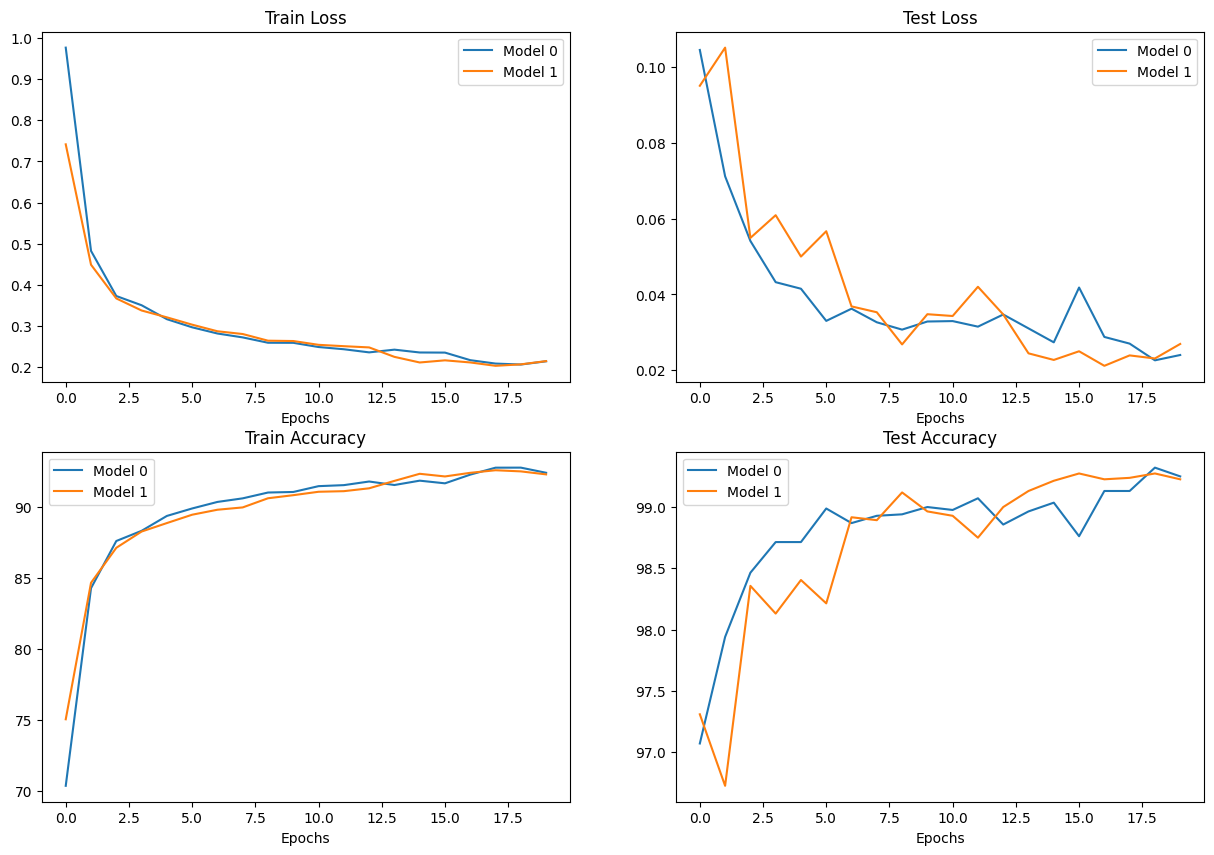

In [46]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["val_loss"], label="Model 0")
plt.plot(epochs, model_1_df["val_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["val_acc"], label="Model 0")
plt.plot(epochs, model_1_df["val_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 8.2 Plot total train times

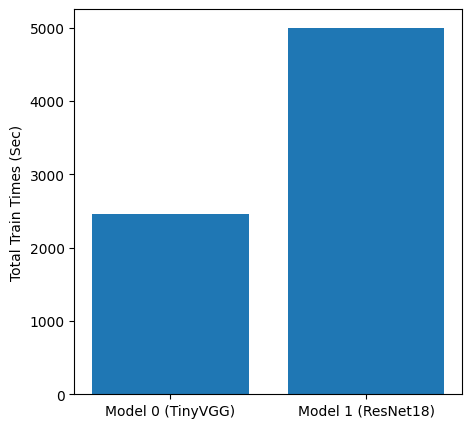

In [47]:
# Setup a plot
plt.figure(figsize=(5, 5))

# Get the data to plot
models = ["Model 0 (TinyVGG)", "Model 1 (ResNet18)"]
total_train_times = [total_train_time_model_0, total_train_time_model_1]

# Plot a bar plot to compare total training times
plt.bar(models, total_train_times)
plt.ylabel("Total Train Times (Sec)");

## 8.3 Confusion matrix

In [48]:
# Make predictions with trained model
preds = []
true = []
model_0.eval()
with torch.inference_mode():
    for X, y in tqdm(val_dataloader, desc="Making Predictions"):
        # Send the data to the target device
        X, y = X.to(device), y.to(device)
        
        # Forward propagation
        logits = model_0(X)
        labels = logits.argmax(dim=1)
        
        # Put predictions on CPU for evaluation and append them to predictions list
        preds.append(labels.cpu())
        
        # Put truth values on CPU and append them to truth values list
        true.append(y.cpu())
        
# Concatenate list of predictions into a tensor and truth labels into a tensor
preds_tensor = torch.cat(preds)
true_tensor = torch.cat(true)
preds_tensor

Making Predictions:   0%|          | 0/84 [00:00<?, ?it/s]

tensor([8, 1, 9,  ..., 3, 0, 9])

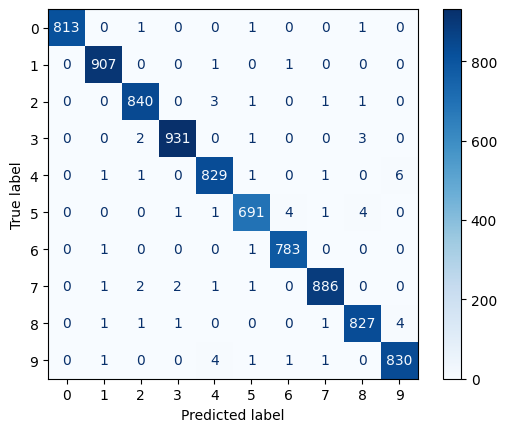

In [49]:
# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true=true_tensor,
                                        y_pred=preds_tensor,
                                        display_labels=class_names,
                                        cmap=plt.cm.Blues,
                                        colorbar=True);